# Replacement path

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
import os
import time
import pickle
import json
from numba import jit
from types import SimpleNamespace
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists
from power_planner.utils.utils_ksp import KspUtils
from power_planner.graphs.implicit_lg import topological_sort_jit, del_after_dest

In [2]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitKSP
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "ch_dump_w1_" + str(SCALE_PARAM) + ".dat")

with open("../../data/instance_CH.nosync/config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        150, 250, cfg.RASTER, SCALE_PARAM
    )
    
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data
    
tic1 = time.time()
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
corridor = np.ones(instance_corr.shape) * 0.5  # start with all

graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=1)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight= 0.1 # cfg.ANGLE_WEIGHT
)
# add vertices
graph.add_nodes()
graph.add_edges()

graph type: <class 'power_planner.graphs.impl_ksp.ImplicitKSP'>
defined pylon distances in raster: 3.0 5.0
cost weights [0.09090909 0.3030303  0.3030303  0.3030303 ]
instance shape (418, 624)
memory taken (dists shape): 7303296
time topo sort: 2.018
stack length 145488
time edges: 3.319


In [3]:
path, path_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
graph.get_shortest_path_tree(start_inds, dest_inds)


time shortest_path_tree: 3.554


### need stack

In [142]:

tmp_list = graph._helper_list()
visit_points = (graph.instance < np.inf).astype(int)
stack = topological_sort_jit(
    start_inds[0], start_inds[1],
    np.asarray(graph.shifts), visit_points, tmp_list
)

In [90]:
some_point = 100
path = np.asarray(path)
s1 = path[some_point]
s2 = path[some_point+1]
shift = s2-s1
shift_ind = np.argmin([np.linalg.norm(s-shift) for s in graph.shifts])
marked = np.zeros(graph.dists.shape)
marked[shift_ind, s2[0], s2[1]] = 1

In [92]:
marked_out = cut_edges(stack, graph.shifts, graph.dists, graph.preds, marked)

In [29]:
@jit(nopython=True)
def cut_edges(stack, shifts, dists, preds, marked):
    """
    Fast C++ (numba) method to compute the cumulative distances from start
    """
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[i][0]
        v_y = stack[i][1]
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            best_shift = preds[s, neigh_x, neigh_y]
            if best_shift>=0 and marked[int(best_shift), v_x, v_y]:
                marked[s, neigh_x, neigh_y] = 1
            elif best_shift<0:
                marked[s, neigh_x, neigh_y] = 2
            # if s==len(shifts)-1:
            # depends on topological sort whether that holds
    return marked

@jit(nopython=True)
def cut_edges_dest(stack, shifts, dists, preds, marked):
    """
    Fast C++ (numba) method to compute the cumulative distances from start
    """
    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[i][0]
        v_y = stack[i][1]
        for s in range(len(shifts)):
            best_shift = int(preds[s, v_x, v_y])
            if best_shift>=0:
                in_neigh_x = v_x - shifts[best_shift][0]
                in_neigh_y = v_y - shifts[best_shift][1]
                if marked[best_shift, in_neigh_x, in_neigh_y]:
                    marked[s, v_x, v_y] = 1
            else:
                marked[s, v_x, v_y] = 2
            # if s==len(shifts)-1:
            # depends on topological sort whether that holds
    return marked

In [36]:
def replacement_path(self, marked_out):
    # get vertices that have edges with the predecessor but also other edges = cut edges
    crit_points_x, crit_points_y = np.where(np.all(np.asarray([np.any(marked_out, axis=0), (1-np.absolute(np.all(marked_out, axis=0)))]), axis=0))
    # np.absolute(np.mean(marked_out, axis=0)-0.5)!=0.5)
    plt.imshow(np.absolute(np.mean(marked_out, axis=0)-0.5)!=0.5)
    plt.title("valid replacement vertices")
    plt.show()
    min_cost = np.inf
    crit_points = []
    crit_dists = []
    for (x,y) in zip(crit_points_x, crit_points_y):
        assert not np.all(marked_out[:,x,y]==1) and not np.all(marked_out[:,x,y]==0)
        # compute distance for each edge
        for s in range(len(marked_out)):
            # cut edge: incoming edge that could replace the tree connection
            if marked_out[s,x,y]==0:
                edge_dist = self.dists[s,x,y] + self.dists_ba[s,x,y] - self.instance[x,y] - self.edge_cost[s,x,y]
                if not np.isnan(edge_dist):
                    crit_points.append((x,y,s))
                    crit_dists.append(edge_dist)
    best_ind = np.argmin(crit_dists)
    b_x, b_y, b_s = crit_points[best_ind]
    print(b_x, b_y, self.shifts[b_s], b_s, np.min(crit_dists))
    vertices_path = self._combined_paths(start_inds, dest_inds, b_s, [b_x, b_y])
    return self.transform_path(vertices_path)
# new_path = replacement_path(graph, marked_out)


In [37]:
def replace_single_edge(self, u_x, u_y, v_x, v_y):
    """
    Compute the best replacement path for the edge (u,v)
    Arguments:
        u_x, u_y, v_x, v_y: Integers defining the coordinates of u and v
    Note: If e=(u,v) is not part of the LCP, then simply the LCP will be returned!
    """
    # get index of edge we want to change
    shift = np.asarray([v_x-u_x, v_y-u_y])
    shift_ind = np.argmin([np.linalg.norm(s-shift) for s in self.shifts])
    marked = np.zeros(self.dists.shape)
    # set this single edge as marked (predecessor to be replaced)
    marked[shift_ind, v_x, v_y] = 1
    
    # mark all edges in subtree of this edge
    marked_out = cut_edges(stack, self.shifts, self.dists, self.preds, marked) # TODO: stack
    
    # compute replacement path
    return replacement_path(self, marked_out) # todo

@jit(nopython=True)
def stack_after_window(stack, w_xmin, w_xmax, w_ymin, w_ymax):
    for i in range(len(stack)):
        if stack[-i-1][0] >= w_xmin and stack[-i-1][0]<=w_xmax and stack[-i-1][1] >= w_ymin and stack[-i-1][1] <= w_ymax:
            return stack[-i-1:]

def replace_window(self, w_xmin, w_xmax, w_ymin, w_ymax):
    # get index of edge we want to change
    marked = np.zeros(self.dists.shape)
    # set this single edge as marked (predecessor to be replaced)
    marked[:, w_xmin:w_xmax+1, w_ymin:w_ymax+1] = 1
    
    # get stack --> in both directions
    tmp_list = graph._helper_list()
    visit_points = (graph.instance < np.inf).astype(int)
    stack_source = topological_sort_jit(
        dest_inds[0], dest_inds[1],
        np.asarray(self.shifts)*(-1), visit_points, tmp_list
    )
    stack_source = del_after_dest(stack_source, self.start_inds[0], self.start_inds[1])
    marked_source = cut_edges(stack_source, np.asarray(self.shifts), self.dists, self.preds, marked.copy())
    visit_points = (graph.instance < np.inf).astype(int)
    # same for T_t
    stack_dest = topological_sort_jit(
        start_inds[0], start_inds[1],
        np.asarray(self.shifts), visit_points, tmp_list
    )
    stack_dest = del_after_dest(stack_dest, self.dest_inds[0], self.dest_inds[1])
    print(len(stack_dest), stack_dest[0])
    marked_dest = cut_edges_dest(stack_dest, np.asarray(self.shifts)*(-1), self.dists_ba, self.preds_ba, marked.copy())
    plt.imshow(np.mean(marked_source, axis=0))
    plt.colorbar()
    plt.show()
    plt.imshow(np.mean(marked_dest, axis=0))
    plt.colorbar()
    plt.show()
    comb_marked = np.any(np.asarray([marked_source, marked_dest]), axis=0)
    # mark all edges in subtree of this edge
    # marked_out = cut_edges(reduced_stack, np.asarray(self.shifts), self.dists, self.preds, comb_marked) # TODO: stack
    # compute replacement path
    return replacement_path(self, comb_marked)


134927 [307, 618]


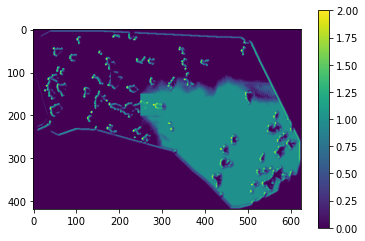

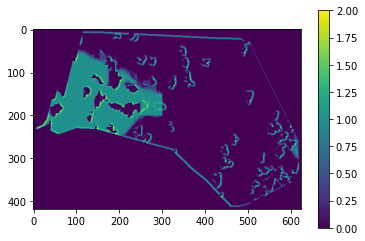

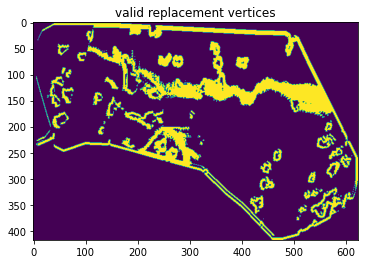

<ipython-input-36-8ca52057984d>:17: RuntimeWarning: invalid value encountered in double_scalars
  edge_dist = self.dists[s,x,y] + self.dists_ba[s,x,y] - self.instance[x,y] - self.edge_cost[s,x,y]


110 281 (0, 5) 13 8.195714217860457


In [40]:
window_path, _, _ = replace_window(graph, 150, 200,250, 300) # DELETE everything before last vertex in forbidden region from stack --> reduces runtime as well
# 0,400,300,350)
# 

In [ ]:
new_path = replace_single_edge(graph, 159, 413, 158, 417)
new_path_coords = np.asarray(new_path[0])
path[100:102], new_path_coords[100:102]

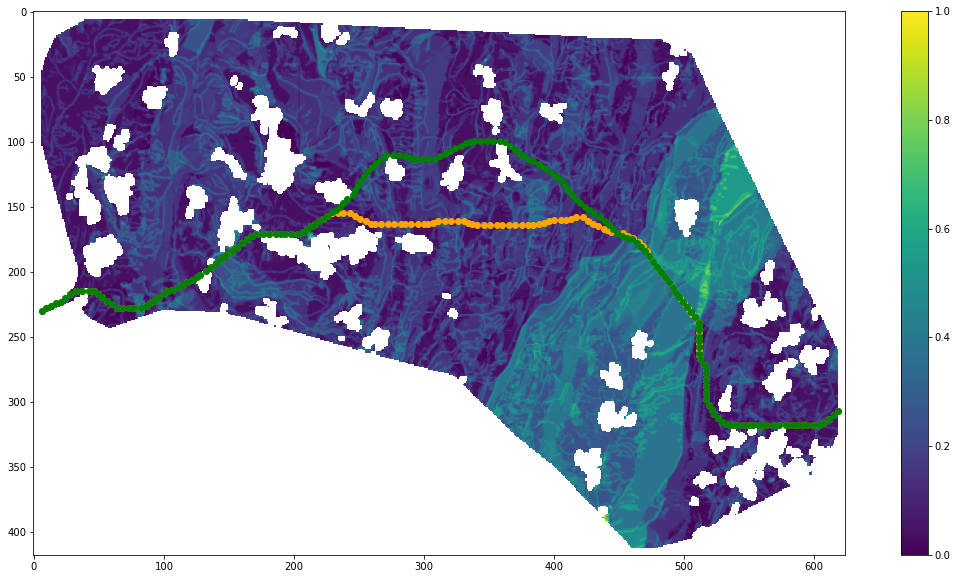

In [41]:
window_path = np.asarray(window_path)
path = np.asarray(path)
plt.figure(figsize=(20,10))
plt.imshow(graph.instance) # np.mean(marked_out, axis=0))

plt.scatter(path[:,1], path[:,0], c="orange")
# plt.scatter(new_path_coords[:,1], new_path_coords[:,0],c="red")
plt.scatter(window_path[:,1], window_path[:,0],c="green")
plt.colorbar()

In [63]:
graph.dists[shift_ind, s2[0], s2[1]]

3.9151606622264805

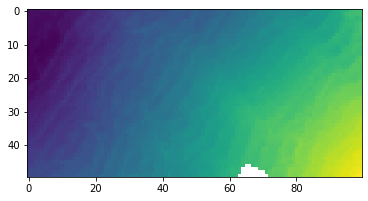

In [123]:
plt.imshow(np.min(graph.dists[:, 200:250, 400:500], axis=0))

In [ ]:
def replace_window_old(self, w_xmin, w_xmax, w_ymin, w_ymax):
    """
    Compute the shortest path AVOIDING a window
    Arguments:
        w_xmin, w_xmax, w_ymin, w_ymax: Integers defining the bounds of the window
    Note: If the window is not part of the LCP, then simply the LCP will be returned!
    """
    # get index of edge we want to change
    marked = np.zeros(self.dists.shape)
    # set this single edge as marked (predecessor to be replaced)
    marked[:, w_xmin:w_xmax+1, w_ymin:w_ymax+1] = 1
    
    # build reduced stack
    tmp_list = graph._helper_list()
    visit_points = (graph.instance < np.inf).astype(int)
    stack = topological_sort_jit(
        dest_inds[0], dest_inds[1],
        np.asarray(graph.shifts)*(-1), visit_points, tmp_list
    )
    # encountered vertices
    # encountered = 1-visit_points[w_xmin:w_xmax+1, w_ymin:w_ymax+1]
    reduced_stack = stack_after_window(stack, w_xmin, w_xmax, w_ymin, w_ymax)
    
    # mark all edges in subtree of this edge
    marked_out = cut_edges(reduced_stack, np.asarray(self.shifts), self.dists, self.preds, marked) # TODO: stack
    plt.imshow(np.mean(marked_out, axis=0))
    plt.show()
    # compute replacement path
    return replacement_path(self, marked_out) # todo

# def stack_after_window(stack, w_xmin, w_xmax, w_ymin, w_ymax, encountered):
#     for i in range(len(stack)):
#         if stack[i][0] >= w_xmin and stack[i][0]<=w_xmax and stack[i][1] >= w_ymin and stack[i][1] <= w_ymax:
#             encountered[stack[i][0]-w_xmin, stack[i][1]-w_ymin] = 1
#         if np.all(encountered):
#             return stack[i:]
#     return encountered